## Rydberg Rabi Flopping Simulation

### Theory

N-Atom Experiments:
 * Strong regime: $\Delta_{dd}$ >> $\Omega$, negligible population in $|r...r>$

### TODO

Simulate Autler-Townes splitting: Let one photon be a strong coupling beam and the other a weak probe, $\Omega_c >> \Omega_p$. AC Stark shift dressed state energy splitting is $\lambda_+ - \lambda_- = \hbar \Omega_c$, so a resonance scan will enable measurement of $\Omega_c$

In [2]:
# not all of these import necessary; many are for debugging
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from sympy import MatrixSymbol,MatMul,Matrix,symbols,Function,pi
from sympy.utilities.lambdify import lambdify
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from sympy.physics.quantum import TensorProduct as TP
from sympy.physics.quantum.commutator import Commutator as comm
import sympy as sp
from numpy import zeros, conj
from arc import *
import time
import os, sys

# local files in parent directory
sys.path.append(os.path.join('..',''))
from physconsts import *
from rbconsts import *
from amophys import hf_coupling
from atomsim import AtomSim, comm

In [3]:
#### atom object from Alkali Rydberg Calculator (ARC)

rb_atom = Rubidium(87)

#### functions

def hf_dipole_elem(state1, state2, q, I=1.5):
    """
    Hyperfine structure dipole matrix element
    Args:
        state1: tuple/list containing n1, L1, F1, mF1, J1
        state2: tuple/list containing n2, L2, F2, mF2, J2
        q: -1, 0, or 1
        I: nuclear spin. 3/2 by default for Rb87
    """
    n1, L1, J1, F1, mF1 = state1
    n2, L2, J2, F2, mF2 = state2
    
    radial = rb_atom.getRadialMatrixElement(n1,L1,J1,n2,L2,J2)
    mat_elem = hf_coupling(F1, mF1, J1, q, F2, mF2, J2, I, RME=radial)
    return mat_elem

def f_dipole_elem(state1, state2, q):
    """
    Fine structure dipole matrix element
    Args
        state1: tuple/list containing n1, L1, J1, mJ1, J1
        state2: tuple/list containing n2, L2, F2, mJ2, J2
        q: -1, 0, or 1
    """
    radial = rb_atom.getRadialMatrixElement(n1,L1,J1,n2,L2,J2)
    mat_elem = clebsch_gordan(1,J,JJ,q,mJ,mJJ)*radial
    return mat_elem


In [4]:
# g_state0 = [5, 0, .5, 2, 0]
# g_state1 = [5, 0, .5, 1, 0]
# e_state_f = [5, 1, 1.5, ] # hyperfine basis
# e_state_j = 
# r_state = 

SyntaxError: invalid syntax (<ipython-input-4-25247f167f9c>, line 4)

In [ ]:
# n1=6
# l1=0
# j1=0.5
# mj1=0.5
# n2=6
# l2=1
# j2=1.5
# mj2=1.5
# q=+1
# print("Cs D2 Transition 6S_{1/2}-->6P_{3/2}")
# print("====================================")
# #Radial Matrix element R_{nlj\rightarrown'l'j'}
# print("R_{nlj-n'l'j'} = %.3f ea_0" % atom.getRadialMatrixElement(n1,l1,j1,n2,l2,j2))
# #Reduced Matrix Element <l||er||l'>
# print("<l||er||l'> = = %.3f ea_0" % atom.getReducedMatrixElementL(n1,l1,j1,n2,l2,j2))
# #Reduced Matrix Element <j||er||j'>
# print("<j||er||j'> = %.3f ea_0" % atom.getReducedMatrixElementJ(n1,l1,j1,n2,l2,j2))
# #Angular Coupling
# print("<nljmj|er|n'l'j'mj'> = %.3f ea_0\n" %\
#         atom.getDipoleMatrixElement(n1,l1,j1,mj1,n2,l2,j2,mj2,q))

In [ ]:
help(hf_coupling)

basis states: (might need more to properly handle decay)  
$|{0}\rangle = |5s_{1/2},F=3,m_F=0\rangle$  
$|{1}\rangle = |5s_{1/2},F=2,m_F=0\rangle$  
$|{e}\rangle = |5p_{3/2},F=2,m_F=1\rangle$  
$|{r}\rangle = |84d_{5/2},J=3/2,m_J=3/3\rangle$

## Rabi Flopping with hard-coded Hamiltonian

In [10]:
# build the hamiltonian

# O1max = 2*pi
# O2max = O1max
# O2 = O2max # constant field intensity
# O1 = O1max # constant field intensity
# D1 = 10*O1max 
# D2 = -D1#  + (O1(t)**2 - O2(t)**2)/(4*D1) # keeps two-photon detuning = 0
# O = abs(O1max*O2max/(2*D1))/(2*pi)
# print(f"Two-photon Rabi frequency = 2*pi*{O:.2f} [arb]")

# H = Matrix([[0,  0,    0,    0],
#             [0,  0,   O1/2,  0],
#             [0, O1/2,  -D1, O2/2],
#             [0,   0,   O2/2, -(D1+D2)]])

# Chris's Hamiltonian. Takes like 30s to do only 10 cycles
# values in GHz
O1 = 2*4.43992
O2 = 2*.616463
D1 = -131.947
D12 = .1145

H = Matrix([[0, O1/2, 0],
            [O1/2, D1, O2/2],
            [0, O2/2, D12]])

In [11]:
## set up the simulation 
N = H.shape[0]
rho0 = zeros(int(N*(N + 1)/2), complex)
rho0[0] = 1 + 0j # population starts in ground state
sim = AtomSim(rho0, t_exp=10, hamiltonian=H, _hbar=1)
sim.eqs

[-1.0*I*(4.43992*r01 - 4.43992*conjugate(r01)),
 -1.0*I*(4.43992*r00 - 131.947*r01 + 0.616463*r02 - 4.43992*r11),
 -1.0*I*(0.616463*r01 + 0.1145*r02 - 4.43992*r12),
 -1.0*I*(-4.43992*r01 + 0.616463*r12 + 4.43992*conjugate(r01) - 0.616463*conjugate(r12)),
 -1.0*I*(-4.43992*r02 + 0.616463*r11 + 132.0615*r12 - 0.616463*r22),
 -1.0*I*(-0.616463*r12 + 0.616463*conjugate(r12))]

In [12]:
t0 = time.time()
rho, t = sim.runsim(t_exp=100)
print(f"Run time: {time.time() - t0}")

Run time: 8.774531126022339


Text(0.5, 1.0, 'Three Level Rabi Flopping')

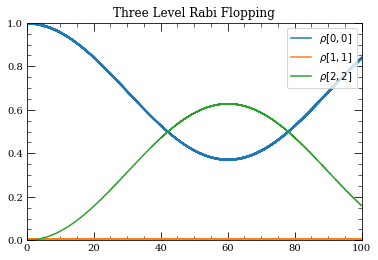

In [13]:
kwargs = {'figsize':(6,4)}
fig, axes = sim.plots(show=['populations'], coherences=False,
                      plt_kwargs=kwargs)
ax = axes[0]
ax.set_ylim((0,1))
ax.set_title('Three Level Rabi Flopping')

### debugging